In [6]:
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random,os,glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen
import warnings 
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix,classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Dense,Dropout,SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img,array_to_img

In [11]:
# veri setini okuma

In [12]:
dir_path = r'C:\Users\user\Desktop\Dektop_AI\Garbage classification'

In [13]:
target_size=(224,224)
waste_labels={'cardboard':0,'glass':1,'metal':2,'paper':3,'plastic':4,'trash':5}

In [15]:
def load_datasets(path):
    x=[]
    labels=[]
    image_paths=sorted(list(paths.list_images(path)))
    for image_path in image_paths:
        img =cv2.imread(image_path)
        img=cv2.resize(img,target_size)
        x.append(img)
        label=image_path.split(os.path.sep)[-2]
        labels.append(waste_labels[label])
    x,labels=shuffle(x,labels,random_state=42)
    print(f"x boyutu:{np.array(x).shape}")
    print(f"label sinif sayisi: {len(np.unique(labels))} gozlem sayisi: {len(labels)}")

    return x,labels

In [20]:
x,labels=load_datasets(dir_path)

x boyutu:(2527, 224, 224, 3)
label sinif sayisi: 6 gozlem sayisi: 2527


In [21]:
input_shape=(np.array(x[0]).shape[1],np.array(x[0]).shape[1],3)
print(input_shape)

(224, 224, 3)


In [24]:
def visualize_img(image_batch,label_batch):
    plt.figure(figsize=(10,10))
    for n in range(10):
        ax=plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels,num_classes=6)[n]==1][0].title())
        plt.axis('off')

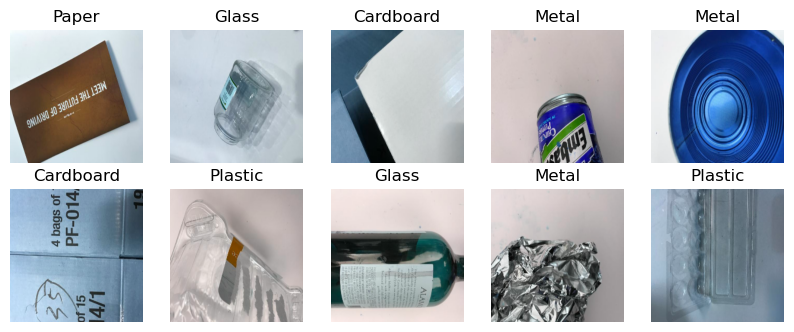

In [25]:
visualize_img(x,labels)

In [28]:
#data preparation
train=ImageDataGenerator(horizontal_flip=True,vertical_flip=True,validation_split=0.1,rescale=1./255,shear_range=0.1,zoom_range=0.1,width_shift_range=0.1,height_shift_range=0.1)
test=ImageDataGenerator(rescale=1/255,validation_split=0.1)
train_generator=train.flow_from_directory(directory=dir_path,target_size=(target_size),class_mode='categorical',subset='training')
test_generator=test.flow_from_directory(directory=dir_path,target_size=(target_size),batch_size=251,class_mode='categorical',subset='validation')


Found 2275 images belonging to 1 classes.
Found 252 images belonging to 1 classes.


In [32]:
#CNN modeli kurma
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',input_shape=(input_shape),activation='relu'))
model.add(MaxPooling2D(pool_size=2,strides=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2,strides=(2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2,strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=64,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=32,activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=6,activation='softmax'))

In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 28, 28, 32)      